In [1]:
import pandas as pd; pd.options.mode.chained_assignment = None # default warn => SettingWithCopyWarning
import numpy as np
from datetime import datetime
import warnings; warnings.simplefilter(action='ignore', category=UserWarning)
from IPython.display import HTML, display
from ipywidgets import AppLayout, Button, Layout, VBox, HBox, Label, HTML, interact, interact_manual, IntSlider
import ipywidgets as widgets
import arrow

#import dmyplant2
from dmyplant2 import (
    cred, MyPlant, Engine, 
    msgFSM, filterFSM, FSMPlot_Start, 
    bokeh_show, dbokeh_chart, add_dbokeh_vlines, get_cycle_data2, 
    disp_result, alarms_pareto, warnings_pareto, states_lines,
    detect_edge_right, detect_edge_left)
    
cred()
mp = MyPlant(3600)
Engine._list_cached_validations();

In [3]:
fleet = mp.search_installed_fleet_by_contains_name('Forsa Hartmoor')
motor = fleet.iloc[0]
text = widgets.Text(value='', placeholder='Searchstring for installed Fleet', description='Search for:', disabled=False)
display(text)

def callback(wdgt):
    global fleet
    fleet = mp.search_installed_fleet_by_contains_name(wdgt.value)

text.on_submit(callback)

Text(value='', description='Search for:', placeholder='Searchstring for installed Fleet')

In [4]:
fleet.T

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
index,23060,23061,23142,23146,23158,23200,23201,23203,23338,23339,...,26641,26642,26643,26644,26645,26646,26647,26648,26649,26650
Count_OpHour,4014.0,3992.0,4023.0,3945.0,4012.0,3976.0,4037.0,4057.0,3981.0,3987.0,...,212.0,193.0,201.0,207.0,213.0,183.0,199.0,186.0,149.0,185.0
OperationalCondition,Available,Available,Available,Available,Available,Available,Available,Available,Available,Available,...,Available,Available,Available,Available,Available,Available,Available,Available,Available,Available
shutdown_counter,2039.0,1990.0,1893.0,1927.0,2066.0,1888.0,1911.0,1952.0,1818.0,2014.0,...,118.0,111.0,111.0,112.0,110.0,97.0,104.0,104.0,95.0,106.0
startup_counter,2038.0,1989.0,1890.0,1924.0,2037.0,1887.0,1910.0,1949.0,1818.0,2011.0,...,117.0,112.0,112.0,112.0,109.0,98.0,105.0,105.0,94.0,102.0
id,132182,132183,132266,132270,132282,132324,132325,132327,132723,132726,...,159397,159398,159399,159400,159401,159402,159403,159404,159405,159406
Engine Version,H312,H312,H312,H312,J12,H312,H312,J12,H312,H312,...,H12,H12,H12,H12,H12,H12,H12,H12,H12,H12
Engine Type,624,624,624,624,616,624,624,616,624,624,...,624,624,624,624,624,624,624,624,624,624
Engine Series,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
Country,GB,GB,GB,GB,GB,GB,GB,GB,GB,GB,...,GB,GB,GB,GB,GB,GB,GB,GB,GB,GB


In [5]:
def f(x=0):
    global motor
    motor = fleet.iloc[x]
interact_manual(f, x = IntSlider(0, 0, fleet.shape[0]-1 , 1, layout=widgets.Layout(width='40%')));

interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='40%'), max=30), Button(descript…

In [6]:
modes = ['???','OFF','MANUAL','AUTO']
success = [True,False]
#success = [True]
motor['IB Site Name'] + ' ' + motor['Engine ID'], modes, success

('FORSA CHADDERTON M03', ['???', 'OFF', 'MANUAL', 'AUTO'], [True, False])

In [7]:
e=Engine.from_fleet(mp,motor)
fsm = msgFSM(e, p_from=e['Commissioning Date'], p_to=datetime.now(), frompickle=True, successtime=600)
fsm.run1(enforce=False, silent=True) # run Finite State Machine
fsm.store()
fsm.starts;

In [8]:
rdf = fsm.starts
rda = rdf[:].reset_index(drop='index')
rda = rda[(rda['mode'].isin(modes) & rda['success'].isin(success))].reset_index(drop='index')
display(HTML(pd.DataFrame.from_dict(e.dash, orient='index').T.to_html(escape=False, index=False)))
#rda[filterFSM.run2filter_content].round(2)
print(f"Starts: {rdf.shape[0]}, Successful: {rdf[rdf['success'] == True].shape[0]}, Failed: {rdf[rdf['success'] == False].shape[0]} => {rdf[rdf['success'] == True].shape[0]/rdf.shape[0]*100.0:3.1f}% starting Reliability in period")

HTML(value='<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th>Na…

Starts: 2082, Successful: 1505, Failed: 577 => 72.3% starting Reliability in period


In [9]:
rda[filterFSM.run2filter_content];

In [10]:
# %load_ext autoreload
# %aimport -pandas, -numpy
# %autoreload 2
# Execute FSM Run 2
#rda = fsm.run2(rda)
#fsm.store()

In [11]:
#rdb = rda[(rda['mode'].isin(['AUTO','MANUAL'])) & ((rda['count_alarms'] > 0) | (rda['count_warnings'] > 0))]
#rdb = rda[rda['synchronize'] < 15.0]
rdb = rda
#rdb[filterFSM.run2filter_content].sort_values(by=["synchronize","loadramp"], ascending=[True,True]).round(2)

,startpreparation,speedup,idle,synchronize,loadramp,maxload,ramprate,targetoperation,rampdown,coolrun,runout
count,2081.00,2045.00,1991.00,1983.00,1981.00,0.0,0.0,1668.00,1981.00,1980.00,1974.00
mean,80.59,20.35,6.30,13.49,385.29,NaN,NaN,6402.58,125.32,5.03,49.32
std,30.55,2.46,8.45,7.96,637.42,NaN,NaN,5982.14,10.42,28.77,1.15
min,0.10,3.84,4.97,0.50,10.40,NaN,NaN,0.00,0.30,0.00,41.87
25%,81.25,18.80,5.49,7.54,138.89,NaN,NaN,1865.31,124.59,0.00,48.37
50%,82.68,20.28,5.67,12.23,138.89,NaN,NaN,4555.69,126.95,0.00,48.85
75%,83.27,21.65,5.86,18.60,138.89,NaN,NaN,9305.20,127.48,10.01,50.52
max,862.23,44.64,295.77,74.28,3624.88,NaN,NaN,59928.31,132.69,1263.60,51.56


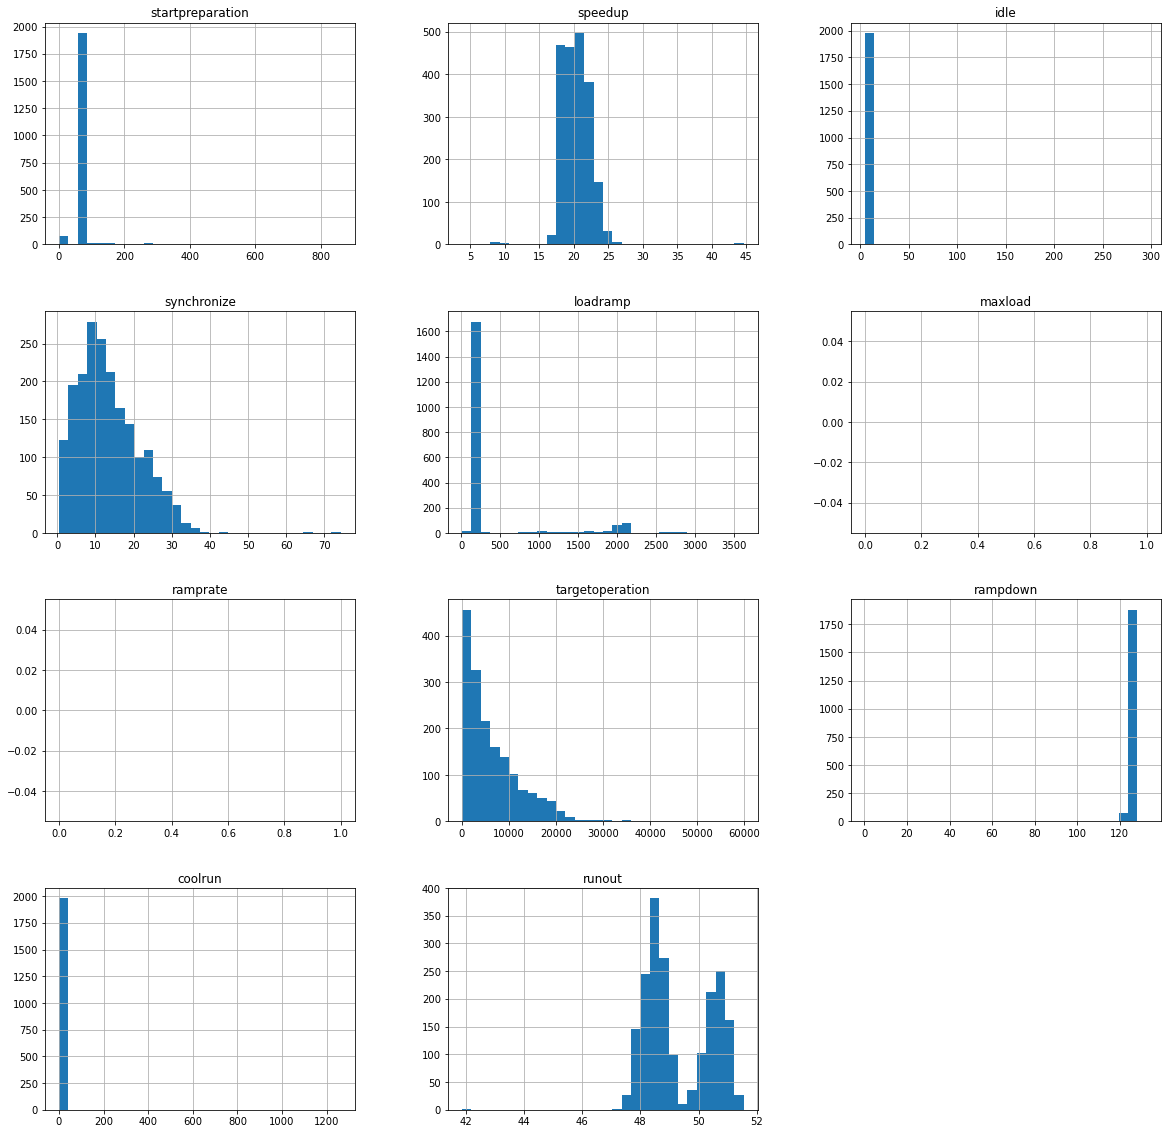

In [12]:
vec = ['startpreparation','speedup','idle','synchronize','loadramp','maxload','ramprate','cumstarttime','targetoperation','rampdown','coolrun','runout']
display(_=rdb[vec].hist(bins=30,figsize=(20,20)))
display(rdb[vec].describe().round(2));

In [13]:
rde = rda[(rda.starttime > fsm._e['Commissioning Date']) & (rda['success'])].copy()
rde['datetime'] = pd.to_datetime(rde['starttime'])
dfigsize = (16,10)
dset = [
    {'col':['cumstarttime'],'ylim':(-400,900), 'color':'darkblue'},
    {'col':['synchronize'],'ylim':(-20,300)},
    {'col':['startpreparation'],'ylim':(-600,300)},
    {'col':['hochlauf'],'ylim':(-100,200), 'color':'orange'},
    {'col':['loadramp'],'ylim':(-150,900), 'color':'red'},
    {'col':['ramprate'],'ylim':(-3,3)},
    {'col':['no'],'ylim':(-100,10000),'color':'black'},
    {'col':['maxload'],'ylim':(500,5000) }
]
ftitle = f"{fsm._e}"
fig = dbokeh_chart(rde, dset, style='both', figsize=dfigsize ,title=ftitle);
bokeh_show(fig)
del(fig)

In [14]:
vset = ['Various_Values_SpeedAct','Power_PowerAct','Hyd_PressCrankCase','Hyd_PressOilDif','Hyd_PressOil','Hyd_TempOil']
dset = [
    {'col':['Power_PowerAct'], 'ylim':(0,5000), 'color':'red'},
    {'col':['Various_Values_SpeedAct'],'ylim': [0, 2500], 'color':'blue'},
    #{'col':['Hyd_PressCrankCase'],'ylim': [-100, 100], 'color':'orange'},
    #{'col':['Hyd_PressOilDif'],'ylim': [0, 2], 'color':'black'},
    {'col':['Hyd_PressOil'],'ylim': [0, 10], 'color':'brown'},
    {'col':['Hyd_TempOil'],'ylim': [0, 110], 'color':'#2171b5'}
]


In [15]:
def plot_with_additional_results(
        startversuch, 
        vset=None, 
        dset = [
        {'col':['Power_PowerAct'], 'ylim':(0,5000), 'color':'red'},
        {'col':['Various_Values_SpeedAct'],'ylim': [0, 2500], 'color':'blue'}
    ]):

    if vset == None:
        vset = []
        for rec in dset:
            for d in rec['col']:
                vset.append(d) 
        vset = list(set(vset))

    data = get_cycle_data2(fsm, startversuch, max_length=None, min_length=None, cycletime=1, silent=False, p_data=vset)
    fig = FSMPlot_Start(fsm, startversuch, data, vset, dset, figsize=dfigsize); 
    #fsm run 2 results
    #lcol='blue'
    # pl, _ = detect_edge_left(data, 'Power_PowerAct', startversuch)
    # pr, _ = detect_edge_right(data, 'Power_PowerAct', startversuch)
    # sl, _ = detect_edge_left(data, 'Various_Values_SpeedAct', startversuch)
    # sr, _ = detect_edge_right(data, 'Various_Values_SpeedAct', startversuch)
    # add_dbokeh_vlines([sl.loc], fig,line_color=lcol, line_dash='solid', line_alpha=0.4)
    # add_dbokeh_vlines([sr.loc], fig,line_color=lcol, line_dash='solid', line_alpha=0.4)
    # add_dbokeh_vlines([pl.loc], fig,line_color=lcol, line_dash='solid', line_alpha=0.4)
    # add_dbokeh_vlines([pr.loc], fig,line_color=lcol, line_dash='solid', line_alpha=0.4)

    #new_lines = [startversuch['starttime']] + [startversuch[k] for k in startversuch.keys() if k.endswith('_time')]
    #add_dbokeh_vlines(new_lines,fig,line_color='green', line_dash='solid', line_alpha=0.4)
    bokeh_show(fig)

In [17]:
def f(x=0):
    global v; v = x; 
    startversuch = rdb.iloc[x]
    ftitle = f"{fsm._e} ----- Start {startversuch['no']} {startversuch['mode']} | {'SUCCESS' if startversuch['success'] else 'FAILED'} | {startversuch['starttime'].round('S')}"
    display(HTML(ftitle));
    disp_result(startversuch)
    plot_with_additional_results(startversuch, vset, dset) 
interact_manual(f, x = IntSlider(0, 0, rdb.shape[0]-1 , 1, layout=widgets.Layout(width='80%')));

interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='80%'), max=2081), Button(descri…

In [ ]:
s = '''
<style>
    table, td, th {
        border: 1px solid grey;
        border-collapse: collapse;
        padding: 5px;
    }
    tfoot {
        text-align: left;
    }
</style>
'''
display(HTML(s + rdb[filterFSM.run2filter_content].sort_values(by=["synchronize","loadramp"], ascending=[True,True]).round(2).to_html(escape=False, index=False, na_rep='', decimal='.')))